In [184]:
pip install tf2onnx onnx onnxruntime

Note: you may need to restart the kernel to use updated packages.


In [185]:
import numpy as np
import re
import os
import cv2
import random 
import onnx
import tf2onnx
import pickle
import onnxruntime as ort
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications import EfficientNetB0 

from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping 



plt.style.use("dark_background")

In [186]:
DATA_ROOT = '/kaggle/input/new-plant-diseases-dataset/'
AUGMENTED_DIR = 'New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'
TRAIN_VAL_DIR = os.path.join(DATA_ROOT, AUGMENTED_DIR)
TEST_PATH = '/kaggle/input/new-plant-diseases-dataset/test/test'

In [187]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


# Load Data

In [188]:
original_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(TRAIN_VAL_DIR, 'train'), 
    image_size = (224,224),
    batch_size = 32,
    label_mode='categorical'
)

valid_dataset =  tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(TRAIN_VAL_DIR, 'valid'),
    image_size = (224,224),
    batch_size = 32,
    label_mode='categorical'
)

Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.


In [189]:
class_names = original_dataset.class_names

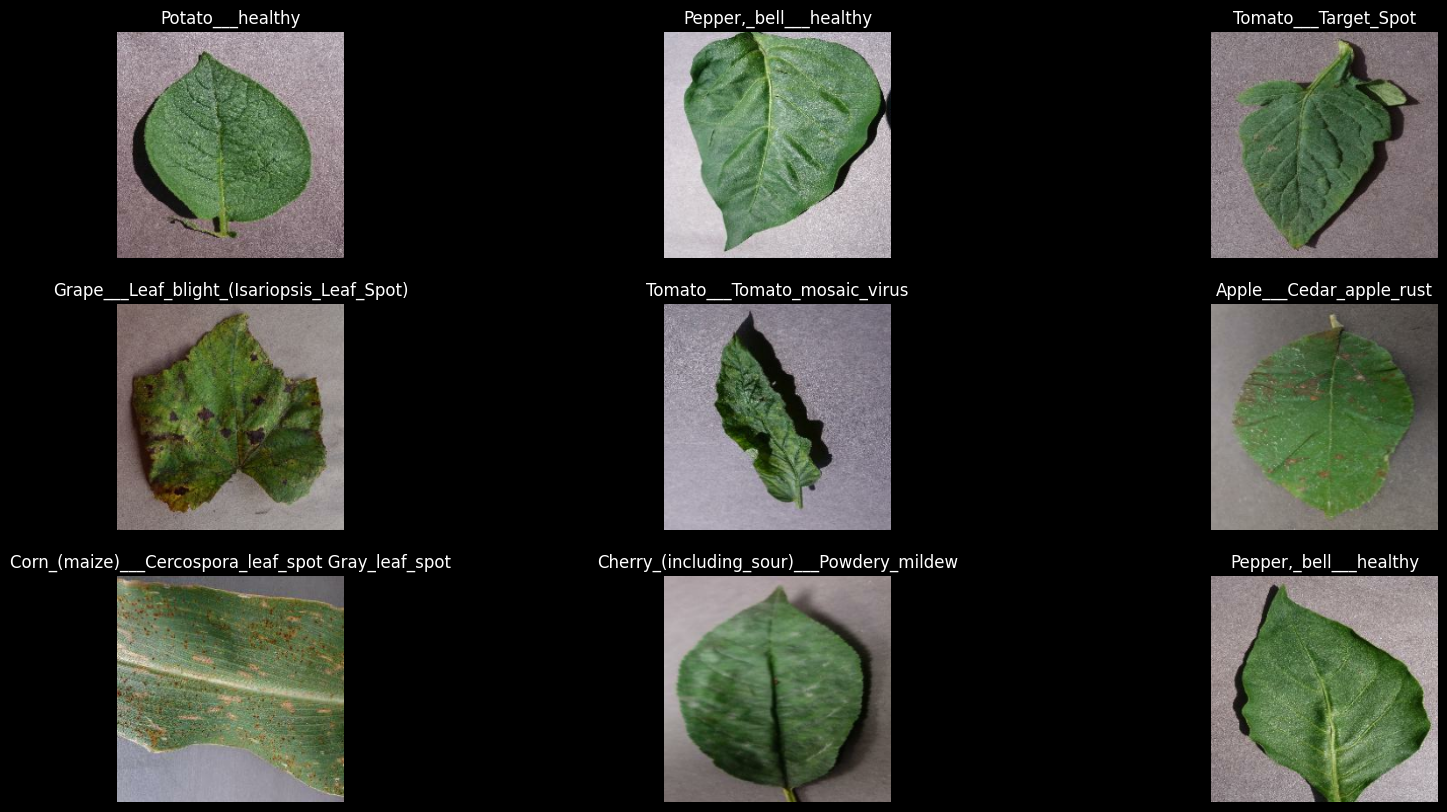

In [190]:
def show_samples(dataset):
    plt.figure(figsize=(20,10))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3,3,i+1)
            plt.imshow(images[i].numpy().astype("uint8"))
            class_index = int(tf.argmax(labels[i]))
            plt.title(class_names[class_index])
            plt.axis("off")


show_samples(original_dataset)

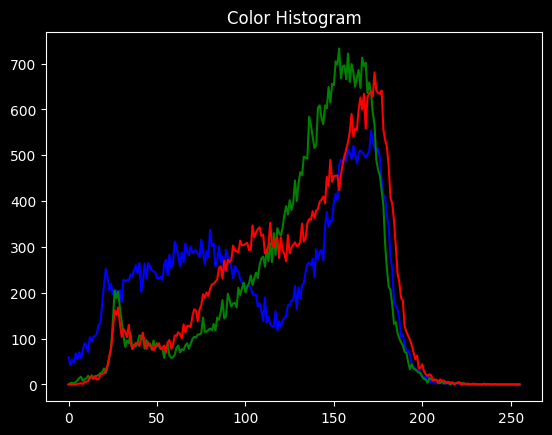

In [191]:
def plot_histogram(image):
    image = image.numpy().astype("uint8")
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    color = ('b', 'g', 'r')
    for i, col in enumerate(color):
        hist = cv2.calcHist([image], [i], None, [256], [0,256])
        plt.plot(hist, color=col)
    plt.title("Color Histogram")
    plt.show()

for images, labels in original_dataset.take(1):
    plot_histogram(images[0])

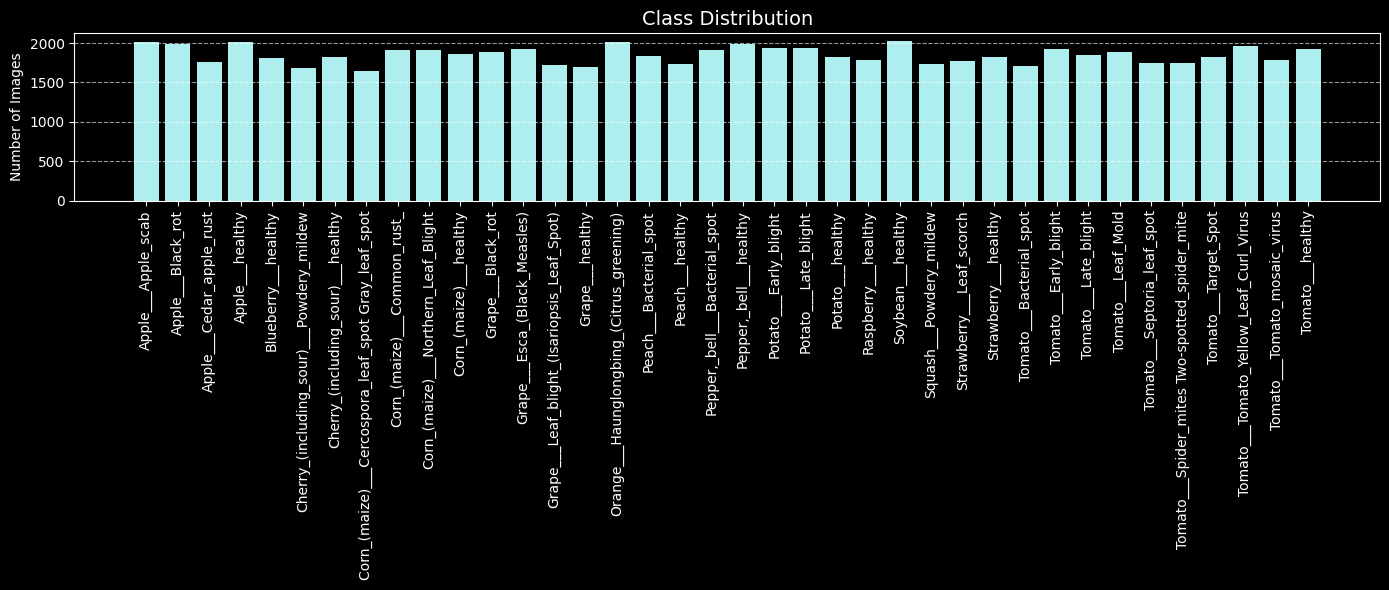

In [192]:
def plot_class_distribution(dataset):
    count_dict = dict.fromkeys(class_names, 0)
    for _, labels in dataset.unbatch():
        class_index = tf.argmax(labels).numpy()
        class_name = class_names[class_index]
        count_dict[class_name] += 1

    plt.figure(figsize=(14, 6))
    plt.bar(count_dict.keys(), count_dict.values(), color='paleturquoise')
    plt.xticks(rotation=90, ha='center', fontsize=10)
    plt.title("Class Distribution", fontsize=14)
    plt.ylabel("Number of Images")
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()

plot_class_distribution(original_dataset)

In [193]:
def t_SNE(model_name, dataset, class_names, max_images=1000):
    model = model_name(include_top=False, pooling='avg', input_shape=(224, 224, 3))
    features = []
    labels = []
    count = 0

    for images, lbls in dataset:
        
        if model_name == ResNet50:
            preprocessed = tf.keras.applications.resnet50.preprocess_input(images)
        elif model_name == EfficientNetB0:
            preprocessed = tf.keras.applications.efficientnet.preprocess_input(images)
        elif model_name == MobileNetV3Small:
            preprocessed = tf.keras.applications.mobilenet_v3.preprocess_input(images)
            
        preds = model(preprocessed, training=False).numpy()
        for i in range(preds.shape[0]):
            features.append(preds[i])
            labels.append(class_names[np.argmax(lbls[i])])
            count += 1
            if count >= max_images:
                break
        if count >= max_images:
            break
    
    features = np.array(features)
    if features.shape[0] == 0:
        print("Không có ảnh để visualize.")
        return
    
    # PCA để giảm nhiễu & tăng hiệu quả t-SNE
    pca = PCA(n_components=50).fit_transform(features)
    tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(pca)

    plt.figure(figsize=(20, 10))
    for label in set(labels):
        idxs = [i for i, l in enumerate(labels) if l == label]
        plt.scatter(tsne[idxs, 0], tsne[idxs, 1], label=label, alpha=0.5, s=30)
    plt.legend(markerscale=2)
    plt.title("t-SNE Feature Space")
    plt.grid(False)
    plt.axis('off')
    plt.show()


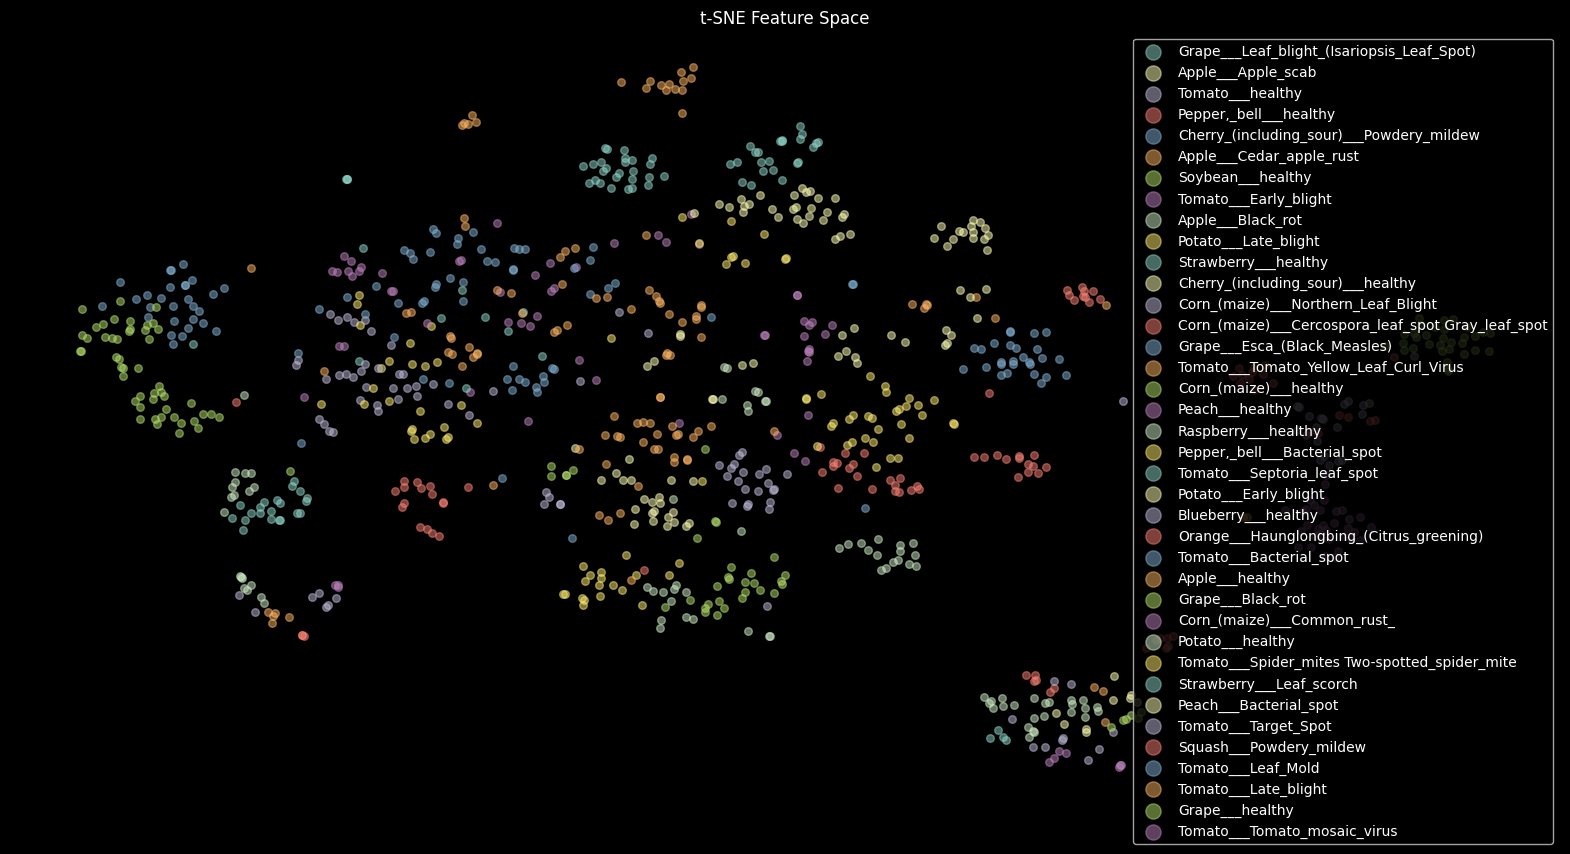

In [194]:
t_SNE(ResNet50,  original_dataset, class_names)

# Preprocess Data

In [195]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

train_dataset = original_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

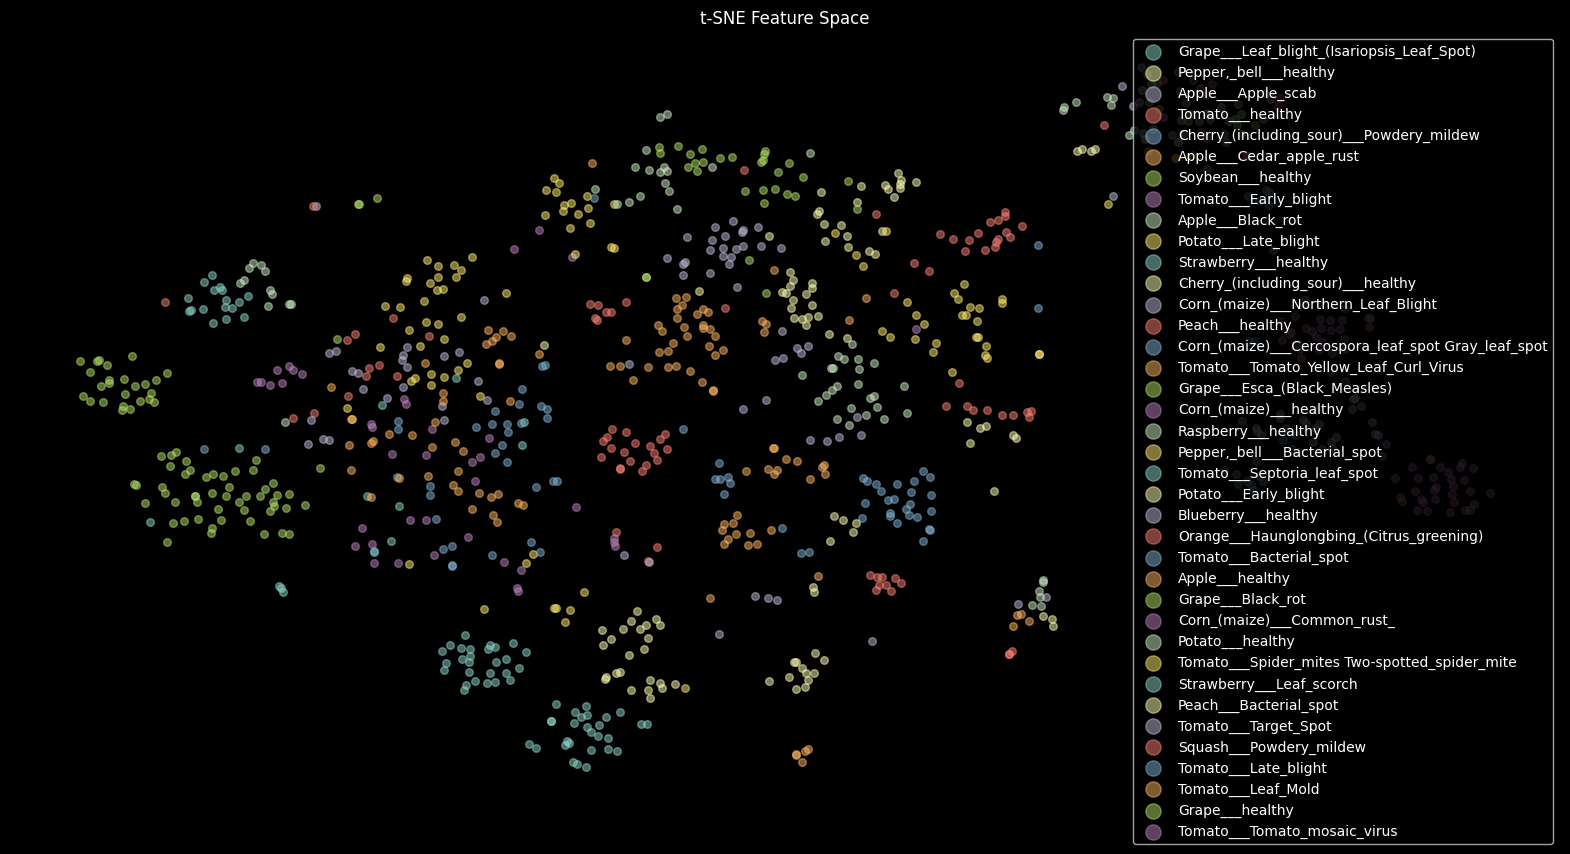

In [196]:
t_SNE(ResNet50 ,  train_dataset, class_names)

# Prepare Model

In [197]:
def build_model(base_model, input_shape=(224,224,3), num_classes=38):
    base_model = base_model(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs = predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model , base_model

In [198]:
# resnet_model = build_model(ResNet50)
# mobilenet_model, base_model = build_model(MobileNetV3Small)
efficient_model, base_model = build_model(EfficientNetB0)

# Train

In [199]:
EPOCHS = 15

In [200]:
def combine_histories(hist1, hist2):
    combined = {}
    for key in hist1.history.keys():
        combined[key] = hist1.history[key] + hist2.history.get(key, [])
    return combined

In [201]:
def train(model, base_model, fine_tune=False, epochs=EPOCHS):
    if not fine_tune:
        # Phase 1: Train không augmentation
        history = model.fit(
            train_dataset, 
            epochs=epochs, 
            validation_data=valid_dataset,
            callbacks=[EarlyStopping(patience=2, restore_best_weights=True)]
        )

        with open('/kaggle/working/history.pkl', 'wb') as f:
            pickle.dump(history.history, f)

        model.save('/kaggle/working/model.h5')

    else:
        # Phase 1: Train với dataset gốc (ko aug)
        history = model.fit(
            original_dataset,
            epochs=8,
            validation_data=valid_dataset,
            callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
        )

        # Phase 2: Fine-tune với aug
        base_model.trainable = True
        for layer in base_model.layers[:-30]:  # chỉ fine-tune 30 layer cuối
            layer.trainable = False

        model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), 
                      loss='categorical_crossentropy', metrics=['accuracy'])

        fine_tune_history = model.fit(
            train_dataset,
            validation_data=valid_dataset,
            epochs=epochs - 8,
            callbacks=[EarlyStopping(patience=2, restore_best_weights=True)]
        )

        # Save model + combined history
        model.save('/kaggle/working/model.h5')

        combined_history = combine_histories(history, fine_tune_history)
        with open('/kaggle/working/combined_history.pkl', 'wb') as f:
            pickle.dump(combined_history, f)

In [202]:
# train(efficient_model, base_model, fine_tune=True, epochs=15)

# Convert .h5 to ONXX

In [203]:
from tensorflow.keras.models import load_model

In [204]:
def conver_2_onnx(model_path, output_name:str):
    model = load_model(model_path)
    spec = (tf.TensorSpec((None, 224, 224, 3), tf.float32, name="input"),)
    model_proto,_ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13)
    with open(output_name, "wb") as f:
        f.write(model_proto.SerializeToString())

    print(f"ONNX model saved to {output_name}")

In [205]:
conver_2_onnx("/kaggle/input/efficientnet/tensorflow2/default/1/model.h5", "efficient.onnx")

I0000 00:00:1745467289.914447      31 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1745467289.914626      31 single_machine.cc:361] Starting new session
I0000 00:00:1745467293.687538      31 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1745467293.687738      31 single_machine.cc:361] Starting new session


ONNX model saved to efficient.onnx


# Predict

In [206]:
efficient_onnx = '/kaggle/working/efficient.onnx'

In [207]:
def remove_duplicate_words(name: str) -> str:
    words = name.split()
    seen = set()
    res = [w for w in words if not (w in seen or seen.add(w))]
    return ' '.join(res)

def normalize_class_name(class_name:str)->str:
    class_name = class_name.replace("___", " ")
    class_name = class_name.replace("_", " ")
    class_name = re.sub(r'[^a-zA-Z0-9 ]', '', class_name)
    class_name = ' '.join(word.capitalize() for word in class_name.split())

    class_name = remove_duplicate_words(class_name)
    return class_name

In [208]:
# img = cv2.imread('/kaggle/input/new-plant-diseases-dataset/test/test/TomatoYellowCurlVirus6.JPG')
# img = cv2.resize(img, (224,224))
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
# img = np.expand_dims(img, axis=0)
# img = img.astype(np.float32)

# input_name = session.get_inputs()[0].name
# outputs = session.run(None, {input_name: img})
# pred_class = np.argmax(outputs)
# print(class_names[pred_class])

In [209]:
def normalize_real_name(name):
    words = re.findall(r'[A-Z][a-z]*', name)
    return ' '.join(words)
    

def predict(model_onnx, path=TEST_PATH):
    pred = []
    session = ort.InferenceSession(model_onnx)
    
    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
        img = np.expand_dims(img, axis=0)
        img = img.astype(np.float32)
            
        input_name = session.get_inputs()[0].name
        outputs = session.run(None, {input_name: img})
        pred_class = np.argmax(outputs)
        format_name = normalize_class_name(class_names[pred_class])
        pred.append(format_name)

    return pred

In [210]:
real = [normalize_real_name(file[:-5]) for file in os.listdir(TEST_PATH)]

In [211]:
pred = predict(efficient_onnx)

# Validation Model

In [212]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

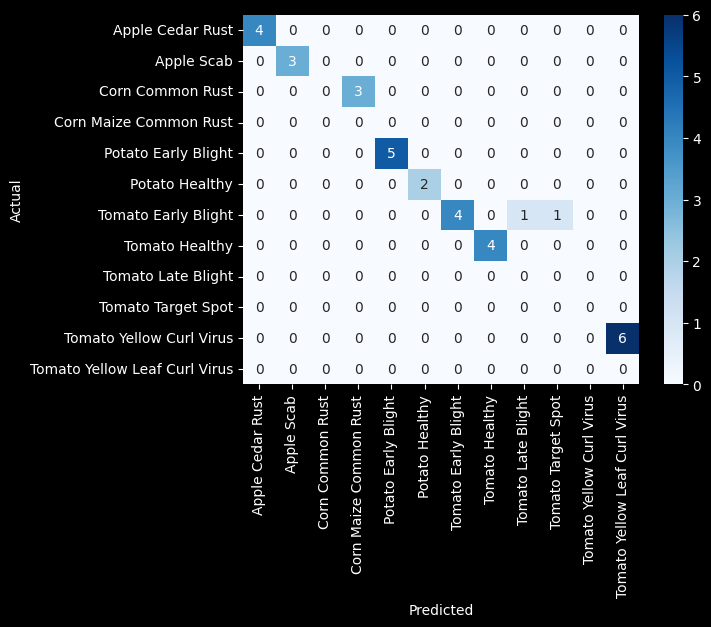

In [213]:
conf_matrix = confusion_matrix(real, pred)
labels = sorted(list(set(real + pred))) 

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Others

In [214]:
with open('/kaggle/input/historyfile/history_mobilenet.pkl', 'rb') as f:
    full_aug_hist = pickle.load(f)

with open('/kaggle/input/historyfile/mobileV3.pkl', 'rb') as f:
    two_stage_hist = pickle.load(f)

## Compare Training Time Strong Aug with Low Aug and Non Aug

Figure X: Per-epoch training time for three augmentation settings: No Augmentation, Low Augmentation, and Strong Augmentation. Strong Augmentation incurs the highest computational cost, while No Augmentation is significantly faster.

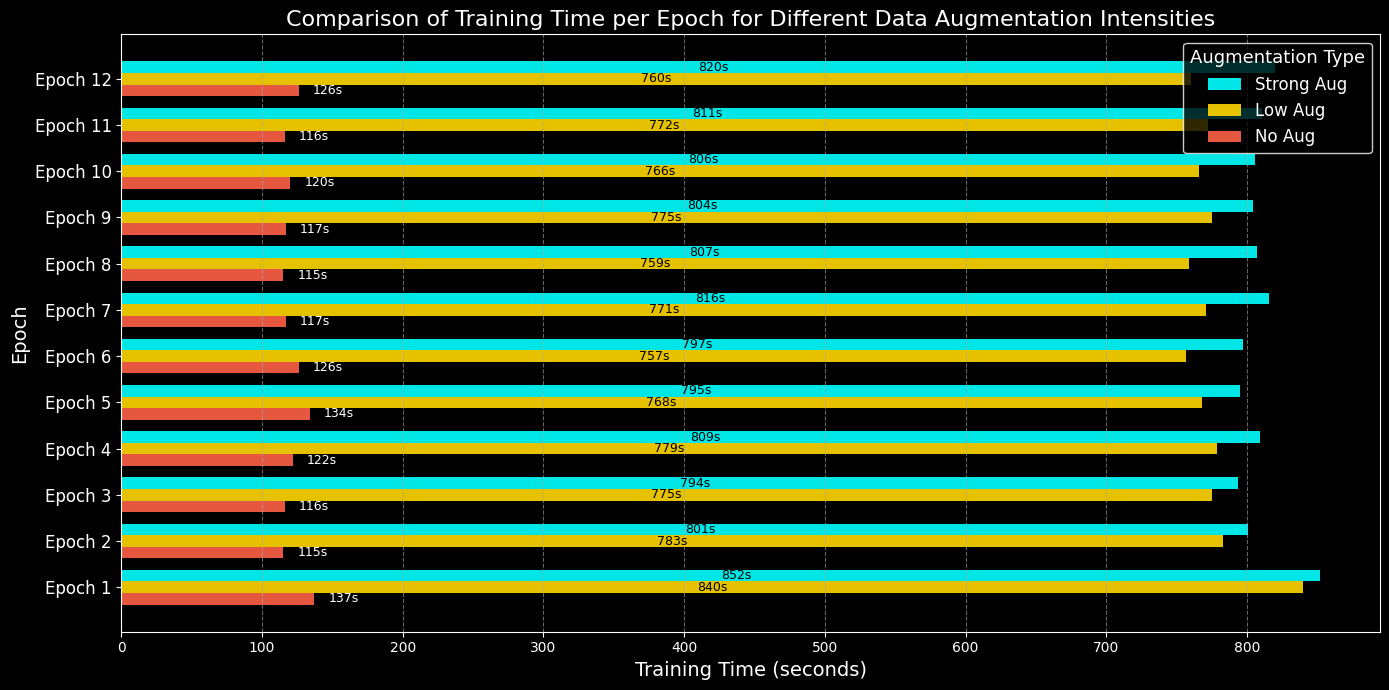

In [215]:
aug_times = [852, 801, 794, 809, 795, 797, 816, 807, 804, 806, 811, 820]
low_aug_times = [840, 783, 775, 779, 768, 757, 771, 759, 775, 766, 772, 760]
no_aug_times = [137, 115, 116, 122, 134, 126, 117, 115, 117, 120, 116, 126]
epochs = np.arange(1, 13)

bar_height = 0.25
y = np.arange(len(epochs))

plt.figure(figsize=(14, 7))

# 
plt.barh(y + bar_height, aug_times, height=bar_height, label='Strong Aug', color='#00FFFF', alpha=0.9)
plt.barh(y, low_aug_times, height=bar_height, label='Low Aug', color='#FFD700', alpha=0.9)
plt.barh(y - bar_height, no_aug_times, height=bar_height, label='No Aug', color='#FF6347', alpha=0.9)

# Ghi chú trên bar
for i in range(len(epochs)):
    plt.text(aug_times[i] / 2, y[i] + bar_height, f'{aug_times[i]}s', va='center', fontsize=9, color='black')
    plt.text(low_aug_times[i] / 2, y[i], f'{low_aug_times[i]}s', va='center', ha='center', fontsize=9, color='black')
    plt.text(no_aug_times[i] + 10, y[i] - bar_height, f'{no_aug_times[i]}s', va='center', fontsize=9, color='white')

# Cài đặt trục và tiêu đề
plt.xlabel('Training Time (seconds)', fontsize=14, color='white')
plt.ylabel('Epoch', fontsize=14, color='white')
plt.title('Comparison of Training Time per Epoch for Different Data Augmentation Intensities', fontsize=16, color='white')
plt.yticks(y, [f'Epoch {e}' for e in epochs], fontsize=12, color='white')
plt.legend(facecolor='black', edgecolor='white', fontsize=12, loc='best', title='Augmentation Type', title_fontsize=13)
plt.grid(axis='x', linestyle='--', alpha=0.6, color='#aaaaaa')

plt.tight_layout()
plt.show()


## Training with fully augmented data and Two-stage training with clean then augmented data


### Training Time

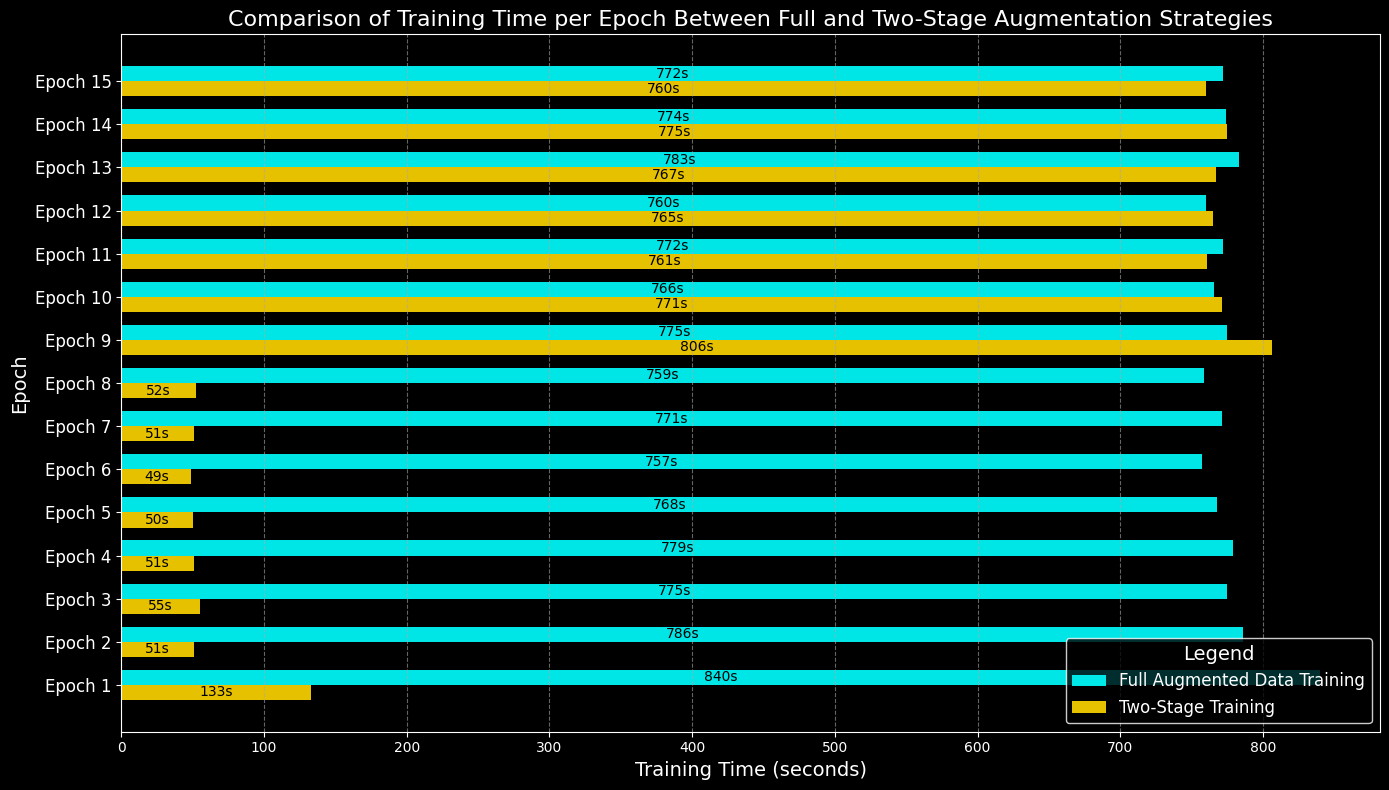

In [216]:
full_aug_times = [840, 786, 775, 779, 768, 757, 771, 759, 775, 766, 772, 760, 783, 774, 772]
two_stage_times = [133, 51, 55, 51, 50,  49, 51, 52, 806, 771, 761, 765, 767, 775, 760]
epochs = np.arange(1, 16)

bar_height = 0.35
y = np.arange(len(epochs))

plt.figure(figsize=(14, 8))

# Draw bars
plt.barh(y + bar_height/2, full_aug_times, height=bar_height, label='Full Augmented Data Training', color='#00FFFF', alpha=0.9)
plt.barh(y - bar_height/2, two_stage_times, height=bar_height, label="Two-Stage Training", color='#FFD700', alpha=0.9)

# Add annotations
for i in range(len(epochs)):
    plt.text(full_aug_times[i] /2, y[i] + bar_height/2, f'{full_aug_times[i]}s', va='center', ha='center', fontsize=10, color='black')
    plt.text(two_stage_times[i] /2, y[i] - bar_height/2, f'{two_stage_times[i]}s', va='center', ha='center', fontsize=10, color='black')

# Labels and ticks
plt.xlabel('Training Time (seconds)', fontsize=14, color='white')
plt.ylabel('Epoch', fontsize=14, color='white')
plt.yticks(y, [f'Epoch {e}' for e in epochs], fontsize=12, color='white')
plt.title("Comparison of Training Time per Epoch Between Full and Two-Stage Augmentation Strategies", fontsize=16, color='white')
plt.legend(facecolor='black', edgecolor='white', fontsize=12, loc='best', title='Legend', title_fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.6, color='#aaaaaa')

plt.tight_layout()
plt.show()


### Validation Accuracy and Loss

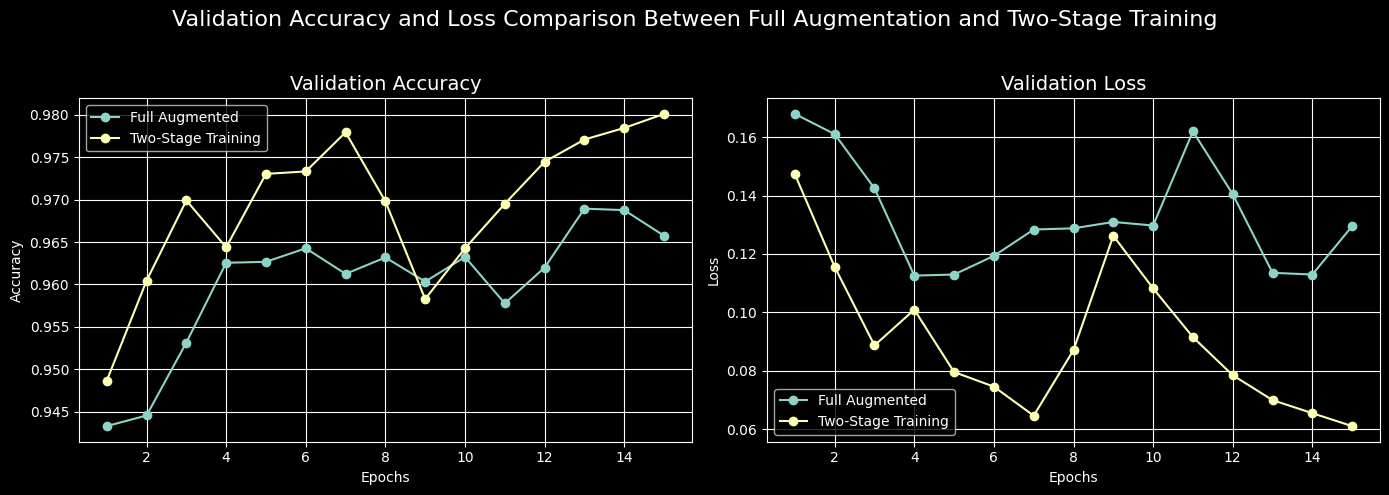

In [217]:
epochs = np.arange(1, len(full_aug_hist['val_accuracy']) + 1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Validation Accuracy and Loss Comparison Between Full Augmentation and Two-Stage Training', fontsize=16)

# --- Validation Accuracy ---
axes[0].plot(epochs, full_aug_hist['val_accuracy'], label='Full Augmented', marker='o')
axes[0].plot(epochs, two_stage_hist['val_accuracy'], label='Two-Stage Training', marker='o')
axes[0].set_title('Validation Accuracy', fontsize=14)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].grid(True)
axes[0].legend()

# --- Validation Loss ---
axes[1].plot(epochs, full_aug_hist['val_loss'], label='Full Augmented', marker='o')
axes[1].plot(epochs, two_stage_hist['val_loss'], label='Two-Stage Training', marker='o')
axes[1].set_title('Validation Loss', fontsize=14)
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

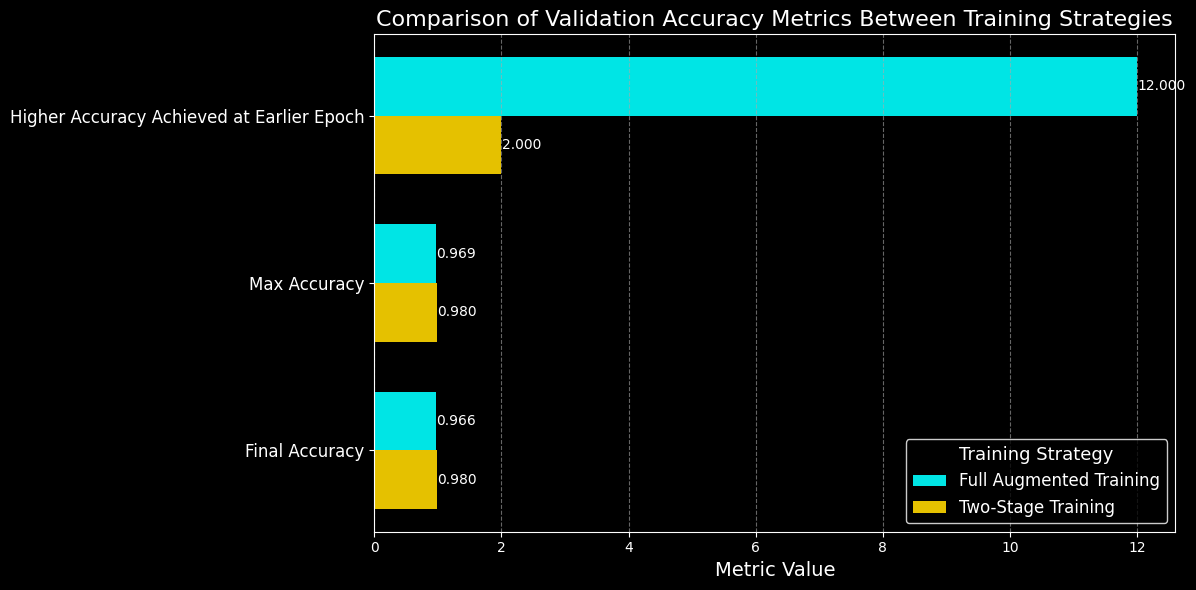

In [218]:
# Define metrics and values
metrics = ['Final Accuracy', 'Max Accuracy', 'Higher Accuracy Achieved at Earlier Epoch']
values_full = [
    full_aug_hist['val_accuracy'][-1],
    max(full_aug_hist['val_accuracy']),
    np.argmax(np.array(full_aug_hist['val_accuracy']) == max(full_aug_hist['val_accuracy']))
]
values_two = [
    two_stage_hist['val_accuracy'][-1],
    max(two_stage_hist['val_accuracy']),
    np.argmax(np.array(two_stage_hist['val_accuracy']) > max(full_aug_hist['val_accuracy']))
]

# Bar chart parameters
y = np.arange(len(metrics))
bar_height = 0.35

plt.figure(figsize=(12, 6))

# Bar charts for both methods
plt.barh(y + bar_height / 2, values_full, height=bar_height, label='Full Augmented Training', color='#00FFFF', alpha=0.9)
plt.barh(y - bar_height / 2, values_two, height=bar_height, label='Two-Stage Training', color='#FFD700', alpha=0.9)

# Annotations
for i, (v1, v2) in enumerate(zip(values_full, values_two)):
    plt.text(v1 + 0.01, i + bar_height / 2, f'{v1:.3f}', va='center', color='white', fontsize=10)
    plt.text(v2 + 0.01, i - bar_height / 2, f'{v2:.3f}', va='center', color='white', fontsize=10)

# Axis labels and title
plt.xlabel('Metric Value', fontsize=14, color='white')
plt.yticks(y, metrics, fontsize=12, color='white')
plt.title('Comparison of Validation Accuracy Metrics Between Training Strategies', fontsize=16, color='white')
plt.legend(facecolor='black', edgecolor='white', fontsize=12, loc='best', title='Training Strategy', title_fontsize=13)
plt.grid(axis='x', linestyle='--', alpha=0.6, color='#aaaaaa')

plt.tight_layout()
plt.show()


### Disparity in Validation Accuracy between Aug Training and Two Stage Training

if vall_acc_diff > 0 at one epoch ⇒ two-stage is better at that epoch.

if vall_acc_diff < 0 at one epoch ⇒ full-aug is better at that epoch.

if 0 ⇒ equal.

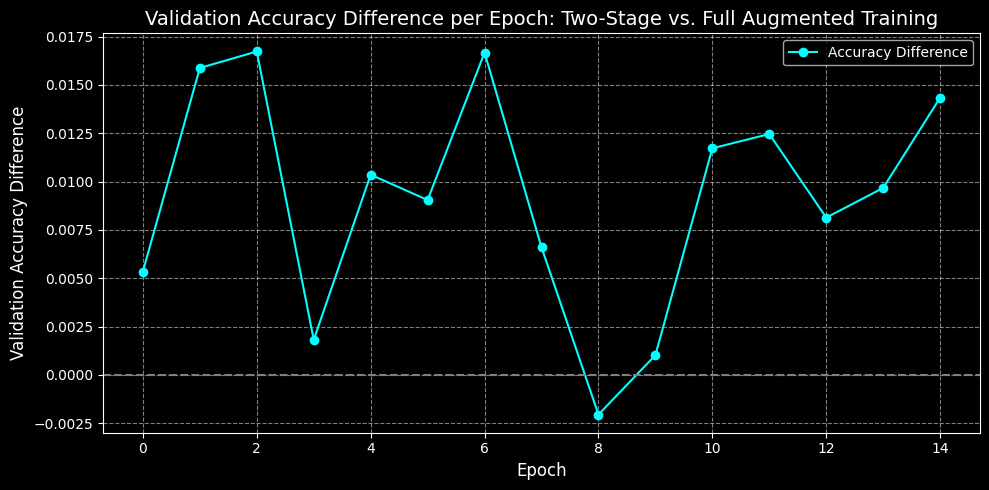

In [219]:
val_acc_diff = np.array(two_stage_hist['val_accuracy']) - np.array(full_aug_hist['val_accuracy'])
plt.figure(figsize=(10, 5))
plt.plot(val_acc_diff, marker='o', linestyle='-', color='cyan', label='Accuracy Difference')
plt.axhline(0, color='gray', linestyle='--')  # baseline
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Validation Accuracy Difference', fontsize=12)
plt.title('Validation Accuracy Difference per Epoch: Two-Stage vs. Full Augmented Training', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

### Area Under the Curve (AUC) 

### UAC 

In [220]:
full_auc = np.sum(full_aug_hist['val_accuracy'])
two_stage_auc = np.sum(two_stage_hist['val_accuracy'])

print(f"Full Augmented AUC: {full_auc:.2f}")
print(f"Two Stage AUC: {two_stage_auc:.2f}")

Full Augmented AUC: 14.40
Two Stage AUC: 14.54
